# Setup

In [ ]:
! pip install -q -U datasets
! pip install -q sentence-transformers
! pip install -q -U huggingface_hub
! pip install -q evaluate
! pip install -q transformers
! pip install -q peft
! pip install -q pandas
! pip install -q nltk

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
dataset_nm = "legacy107/newsqa"
chunked_dataset_nm = "legacy107/newsqa-chunked-100"
retrieved_dataset_nm = "legacy107/newsqa-retrieved-ce-chunk-100"

model_nm = "google/flan-t5-large"
max_length = 512
max_target_length = 200
checkpoint = "flan-t5-large-ia3-newsqa-100"
username = "legacy107"

# Data preprocessing and Chunking

In [ ]:
from datasets import load_dataset, DatasetDict, Dataset

In [ ]:
dataset = load_dataset(dataset_nm)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answers', 'key', 'labels', 'document_id'],
        num_rows: 69960
    })
    validation: Dataset({
        features: ['context', 'question', 'answers', 'key', 'labels', 'document_id'],
        num_rows: 4200
    })
    test: Dataset({
        features: ['context', 'question', 'answers', 'key', 'labels', 'document_id'],
        num_rows: 4212
    })
})

## Add document index to each row

In [ ]:
import pandas as pd

contexts = [
    *list(dataset["train"]["context"]),
    *list(dataset["validation"]["context"]),
    *list(dataset["test"]["context"]),
]
context_df = pd.DataFrame(contexts)
# Create a dictionary to map unique contexts to document IDs
context_to_id = {context: idx for idx, context in enumerate(context_df[0].unique())}


def add_document_id(ds):
    df = pd.DataFrame(ds)

    # Add a new column 'document_id' based on the 'context' column
    df["document_id"] = df["context"].map(context_to_id)
    return Dataset.from_pandas(df)


dataset["train"] = add_document_id(dataset["train"])
dataset["validation"] = add_document_id(dataset["validation"])
dataset["test"] = add_document_id(dataset["test"])

In [ ]:
dataset.push_to_hub(dataset_nm)

## Context chunking

In [ ]:
import nltk

nltk.download("punkt")

article_cache = {}


def chunk_text(row, chunk_size=100, overlap=0.10):
    global article_cache

    overlap_size = chunk_size * overlap

    if row["document_id"] in article_cache.keys():
        row["chunks"] = article_cache[row["document_id"]]
        return row

    sentences = nltk.sent_tokenize(row["context"])

    chunks = []
    text = sentences[0]

    if len(sentences) == 1:
        chunks.append(text)
        row["chunks"] = chunks
        article_cache[row["document_id"]] = chunks
        return row

    i = 1
    while i < len(sentences):
        text += " " + sentences[i]
        i += 1
        while (
            i < len(sentences)
            and len(nltk.word_tokenize(f"{text} {sentences[i]}")) <= chunk_size
        ):
            text += " " + sentences[i]
            i += 1

        text = (
            text.replace('"', '"')
            .replace("'", "'")
            .replace("\n\n\n", " ")
            .replace("\n\n", " ")
            .replace("\n", " ")
        )
        chunks.append(text)

        if i >= len(sentences):
            break

        j = i - 1
        text = sentences[j]
        while (
            j >= 0 and len(nltk.word_tokenize(f"{sentences[j]} {text}")) <= overlap_size
        ):
            text = sentences[j] + " " + text
            j -= 1

    row["chunks"] = chunks
    article_cache[row["document_id"]] = chunks

    return row

In [ ]:
dataset = dataset.map(chunk_text, batched=False, num_proc=2)

In [ ]:
dataset.push_to_hub(chunked_dataset_nm)

In [ ]:
# Show average chunk length histogram
df = pd.DataFrame(list(article_cache.items()), columns=["document_id", "chunks"])
df["chunks"].apply(
    lambda x: sum(len(nltk.word_tokenize(chunk)) for chunk in x) / len(x)
).hist()

<Axes: >

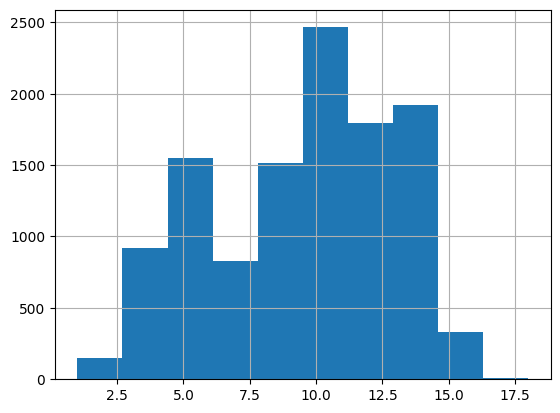

In [ ]:
# Show number of chunks histogram
df["chunks"].apply(len).hist()

# Retrieve context using Cross-encoder model

In [ ]:
dataset = load_dataset(chunked_dataset_nm)

In [ ]:
from sentence_transformers import CrossEncoder

cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

In [ ]:
def retrieve_context(row):
    query = row["question"]

    hits = [{"corpus_id": i} for i in range(len(row["chunks"]))]
    cross_inp = [[query, row["chunks"][hit["corpus_id"]]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp, show_progress_bar=False)

    for idx in range(len(cross_scores)):
        hits[idx]["cross-score"] = cross_scores[idx]

    hits = sorted(hits, key=lambda x: x["cross-score"], reverse=True)

    # Rerank only and truncate later by tokenizer instead of retrieving top k
    row["retrieved_context"] = " ".join(
        [row["chunks"][hit["corpus_id"]] for hit in hits]
    ).replace("\n", " ")

    return row

In [ ]:
dataset = dataset.map(retrieve_context, batched=False)

In [ ]:
dataset.remove_columns("chunks").push_to_hub(retrieved_dataset_nm)

Map (num_proc=2):   0%|          | 0/4212 [00:00<?, ? examples/s]

Map:   0%|          | 0/4212 [00:00<?, ? examples/s]

96.20


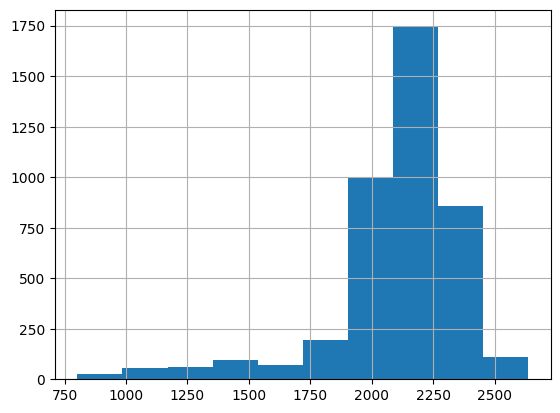

In [ ]:
import pandas as pd

# Show information retrieval accuracy
subset = "test"


def compose_prompt(ds):
    qa_input = f"question: {ds['question']} " f"context: {ds['retrieved_context']}"
    inputs = tokenizer(
        qa_input,
        truncation=True,
        max_length=max_length,
    )
    ds["input"] = inputs.input_ids
    ds["input"] = tokenizer.decode(ds["input"], skip_special_tokens=True)
    return ds


dataset[subset] = dataset[subset].map(compose_prompt, batched=False, num_proc=2)
df = pd.DataFrame(dataset[subset])
df["input"].apply(len).hist()

match = 0


def find_match(row):
    global match
    match = match + (1 if row["answers"][0] in row["input"] else 0)


dataset[subset].map(find_match, batched=False)

print("%.2f" % (match / dataset[subset].num_rows * 100))

# Prepare dataset for MRC training

In [ ]:
from datasets import load_dataset

dataset = load_dataset(retrieved_dataset_nm)

dataset = dataset.remove_columns(["document_id", "context"])
dataset = dataset.rename_columns({"retrieved_context": "context"})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answers', 'key', 'labels', 'context'],
        num_rows: 69960
    })
    validation: Dataset({
        features: ['question', 'answers', 'key', 'labels', 'context'],
        num_rows: 4200
    })
    test: Dataset({
        features: ['question', 'answers', 'key', 'labels', 'context'],
        num_rows: 4212
    })
})

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

tokenizer = AutoTokenizer.from_pretrained(model_nm, device_map="auto")


def qa_prompt_preprocess(ds):
    input = f"question: {ds['question']} " f"context: {ds['context']}"
    inputs = tokenizer(input, max_length=max_length, truncation=True)

    ds["input"] = inputs.input_ids
    ds["input"] = tokenizer.decode(ds["input"], skip_special_tokens=True)
    return ds


dataset = dataset.map(qa_prompt_preprocess, batched=False, num_proc=2)

In [ ]:
match = 0


def find_match(row):
    global match
    match = match + (1 if row["answers"][0] in row["input"] else 0)

In [ ]:
match = 0
dataset["train"].map(find_match, batched=False)
print("Train: %.2f" % (match / dataset["train"].num_rows * 100))

match = 0
dataset["validation"].map(find_match, batched=False)
print("Validation: %.2f" % (match / dataset["validation"].num_rows * 100))

match = 0
dataset["test"].map(find_match, batched=False)
print("Test: %.2f" % (match / dataset["test"].num_rows * 100))

IR accuracy (answer in context)

**Input (truncated)**
- Train: 95.77
- Validation: 95.67
- Test: 96.20

**Retrieved context (not truncated)**
- Train: 99.95
- Validation: 100
- Test: 99.98

In [ ]:
# Filter out examples where the answer is not in the input
dataset["train"] = dataset["train"].filter(
    lambda row: row["answers"][0] in row["input"]
)
dataset["validation"] = dataset["validation"].filter(
    lambda row: row["answers"][0] in row["input"]
)
dataset

In [ ]:
dataset.save_to_disk("./newsqa-ce-chunk-100-100%")

In [ ]:
from datasets import DatasetDict

dataset = DatasetDict.load_from_disk("./newsqa-ce-chunk-100-100%")

# Evaluating function

In [ ]:
import evaluate


def evaluate_qa(predicted_result):
    squad_metric = evaluate.load("squad")
    predictions = [
        {"prediction_text": row["output"], "id": str(row["key"])}
        for row in predicted_result
    ]
    references = [
        {
            "answers": {
                "answer_start": row["labels"][0]["start"],
                "text": row["answers"],
            },
            "id": str(row["key"]),
        }
        for row in predicted_result
    ]
    results = {}
    results["squad"] = squad_metric.compute(
        predictions=predictions, references=references
    )

    predictions = predicted_result["output"]
    references = predicted_result["answers"]

    bleu_metrics = evaluate.load("bleu")
    results["bleu"] = bleu_metrics.compute(
        predictions=predictions, references=references
    )

    return results

# Evaluate pretrained model by 0-shot prompting

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

tokenizer = AutoTokenizer.from_pretrained(model_nm, device_map="auto")
model = AutoModelForSeq2SeqLM.from_pretrained(model_nm, device_map="auto")

In [ ]:
def inference(ds):
    qa_input = [
        f"question: {ds['question'][idx]} " f"context: {ds['context'][idx]}"
        for idx in range(len(ds["question"]))
    ]
    inputs = tokenizer(
        qa_input,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_length,
    ).to(torch.device("cuda"))
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        do_sample=False,
        max_new_tokens=max_target_length,
    )
    ds["output"] = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return ds


model.eval()
with torch.no_grad():
    predicted_result = dataset["test"].map(inference, batched=True, batch_size=16)

In [ ]:
evaluate_qa(predicted_result)

{'squad': {'exact_match': 30.508072174738842, 'f1': 45.685996032709},
 'bleu': {'bleu': 0.1466251714104335,
  'precisions': [0.2418628082057597,
   0.1595545543957613,
   0.12101888136800855,
   0.09896980182447311],
  'brevity_penalty': 1.0,
  'length_ratio': 1.8025021439741715,
  'translation_length': 35731,
  'reference_length': 19823}}

# Finetune MRC model

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModelForSeq2SeqLM, get_peft_config

config = {
    "peft_type": "IA3",
    "task_type": "SEQ_2_SEQ_LM",
    "inference_mode": False,
    "target_modules": ["q", "v", "wo"],
    "feedforward_modules": ["wo"],
}

peft_config = get_peft_config(config)
tokenizer = AutoTokenizer.from_pretrained(model_nm)
model = AutoModelForSeq2SeqLM.from_pretrained(model_nm)
peft_model = PeftModelForSeq2SeqLM(model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 282,624 || all params: 783,432,704 || trainable%: 0.03607508322756973


In [ ]:
def qa_prompt_preprocess(ds):
    input = f"question: {ds['question']} " f"context: {ds['context']}"
    model_inputs = tokenizer(input, max_length=max_length, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(
        text_target=ds["answers"][0], max_length=max_target_length, truncation=True
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


seq2seq_dataset = {
    "train": dataset["train"].map(qa_prompt_preprocess, batched=False, num_proc=2),
    "test": dataset["validation"].map(qa_prompt_preprocess, batched=False, num_proc=2),
}

In [ ]:
seq2seq_dataset

{'train': Dataset({
     features: ['labels', 'input_ids', 'attention_mask'],
     num_rows: 67000
 }),
 'test': Dataset({
     features: ['labels', 'input_ids', 'attention_mask'],
     num_rows: 4018
 })}

In [ ]:
seq2seq_dataset["train"] = seq2seq_dataset["train"].remove_columns(
    ["question", "answers", "key", "context", "input"]
)
seq2seq_dataset["test"] = seq2seq_dataset["test"].remove_columns(
    ["question", "answers", "key", "context", "input"]
)

In [ ]:
import evaluate

squad_metric = evaluate.load("squad")
bleu_metrics = evaluate.load("bleu")


def compute_metrics(pred):
    labels_ids, pred_ids = pred

    pred_ids[pred_ids == -100] = tokenizer.pad_token_id
    predictions = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    references = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    squad_predictions = [
        {"prediction_text": answer, "id": str(id)}
        for id, answer in enumerate(predictions)
    ]
    squad_references = [
        {
            "answers": {"answer_start": [-1], "text": [answer]},
            "id": str(id),
        }
        for id, answer in enumerate(references)
    ]
    results = {}
    results["squad"] = squad_metric.compute(
        predictions=squad_predictions, references=squad_references
    )

    results["bleu"] = bleu_metrics.compute(
        predictions=predictions, references=references
    )

    return results

In [ ]:
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR
from transformers.trainer_callback import TrainerCallback
import os


class SavePeftModelCallback(TrainerCallback):
    def on_save(
        self,
        args,
        state,
        control,
        **kwargs,
    ):
        checkpoint_folder = os.path.join(
            args.output_dir, f"{PREFIX_CHECKPOINT_DIR}-{state.global_step}"
        )

        peft_model_path = os.path.join(checkpoint_folder, "adapter_model")
        kwargs["model"].save_pretrained(peft_model_path)

        pytorch_model_path = os.path.join(checkpoint_folder, "pytorch_model.bin")
        if os.path.exists(pytorch_model_path):
            os.remove(pytorch_model_path)
        return control

In [ ]:
from transformers import (
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)

bs = 8
eval_bs = 8
epochs = 2
lr = 4e-3
steps = 5000
training_args = Seq2SeqTrainingArguments(
    output_dir=f"./{checkpoint}",
    learning_rate=lr,
    # per_device_train_batch_size=bs,
    # per_device_eval_batch_size=eval_bs,
    auto_find_batch_size=True,
    num_train_epochs=epochs,
    # max_steps=69000,
    warmup_ratio=0.05,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    push_to_hub=True,
    save_strategy="steps",
    save_steps=steps,
    logging_steps=steps,
    logging_first_step=True,
    evaluation_strategy="steps",
    eval_steps=steps,
    predict_with_generate=True,
    generation_max_length=max_target_length,
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=peft_model,
    padding="max_length",
    max_length=max_length,
    return_tensors="pt",
)

trainer = Seq2SeqTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=seq2seq_dataset["train"].with_format("torch"),
    eval_dataset=seq2seq_dataset["test"].with_format("torch"),
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[SavePeftModelCallback],
)

In [ ]:
trainer.train()

In [ ]:
trainer.model.save_pretrained(checkpoint)
tokenizer.save_pretrained(checkpoint)

trainer.model.push_to_hub(checkpoint)
tokenizer.push_to_hub(checkpoint)

In [ ]:
# Merge and Push
merged_model = checkpoint_model.merge_and_unload()
merged_model.push_to_hub(f"{checkpoint}-merged")
tokenizer.push_to_hub(f"{checkpoint}-merged")

# Evaluate

In [ ]:
from transformers import AutoTokenizer
from peft import AutoPeftModelForSeq2SeqLM

model_checkpoint = f"{username}/{checkpoint}"
# model_checkpoint = f"./{checkpoint}/checkpoint-55000"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, device_map="auto")
checkpoint_model = AutoPeftModelForSeq2SeqLM.from_pretrained(
    model_checkpoint, device_map="auto"
)

In [ ]:
import torch


def inference(ds):
    qa_input = [
        f"question: {ds['question'][idx]} " f"context: {ds['context'][idx]}"
        for idx in range(len(ds["question"]))
    ]
    inputs = tokenizer(
        qa_input,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_length,
    ).to(torch.device("cuda"))
    outputs = checkpoint_model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        do_sample=False,
        max_new_tokens=max_target_length,
    )
    ds["output"] = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return ds


checkpoint_model.eval()
with torch.no_grad():
    predicted_result = predicted_result.map(inference, batched=True, batch_size=8)

In [ ]:
evaluate_qa(predicted_result)

{'squad': {'exact_match': 55.959164292497626, 'f1': 70.75449700847965},
 'bleu': {'bleu': 0.23312011105266214,
  'precisions': [0.46838716487228205,
   0.43173181324647125,
   0.42198612696461496,
   0.41531990259021473],
  'brevity_penalty': 0.5372850453092062,
  'length_ratio': 0.6168169536768775,
  'translation_length': 18948,
  'reference_length': 30719}}

In [ ]:
predicted_result.to_csv("./predicted_result.csv")

# Analysis for different answer lengths and question types

In [ ]:
def get_answer(row):
    row["answer"] = row["answers"][0]
    return row


predicted_result = predicted_result.map(get_answer)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(2, 4]      1041
(1, 2]       978
(4, 10]      947
(0, 1]       829
(10, 30]     393
Name: bin, dtype: int64


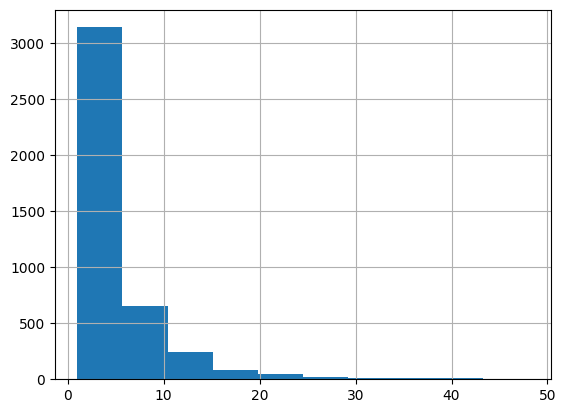

In [ ]:
import pandas as pd
import nltk

nltk.download("punkt")

# Load the dataset into a pandas dataframe
df = pd.DataFrame(predicted_result)

# Tokenize the answer column using nltk
df["answer_tokens"] = df["answer"].apply(nltk.word_tokenize)

# Count the number of words in each answer
df["answer_word_count"] = df["answer_tokens"].apply(len)
df["answer_word_count"].hist()

# Create bins based on the word count
bins = [0, 1, 2, 4, 10, 30]

# Assign each row to a bin based on the word count
df["bin"] = pd.cut(df["answer_word_count"], bins=bins)

# Print the number of rows in each bin
print(df["bin"].value_counts())

In [ ]:
import pandas as pd


def get_prefix(row):
    row["prefix"] = row["question"].split()[0].lower()
    return row


predicted_result = predicted_result.map(get_prefix)

df = pd.DataFrame(predicted_result)

print(df["prefix"].value_counts()[:15])

what      1843
who        999
where      355
how        313
when       167
which      117
in          33
the         29
for         19
did         19
whose       18
is          14
on          11
name         9
number       9
Name: prefix, dtype: int64


In [ ]:
from datasets import Dataset

groups = df.groupby("bin")
group_labels = list(groups.groups.keys())
results = []
for label in group_labels:
    result = evaluate_qa(
        Dataset.from_pandas(groups.get_group(label).drop("bin", axis=1))
    )
    results.append(
        {
            "label": str(label),
            "em": result["squad"]["exact_match"],
            "f1": result["squad"]["f1"],
            "bleu": result["bleu"]["bleu"] * 100,
        }
    )

print(results)

In [ ]:
import pandas as pd

df_result = pd.DataFrame(results)
df_result = df_result.reset_index(drop=True)
df_result.to_csv("result_ia3.csv", index=False)

In [ ]:
from datasets import Dataset

groups = df.groupby("prefix")
group_labels = ["what", "who", "where", "how", "when", "which", "whose"]
results = []
for label in group_labels:
    result = evaluate_qa(
        Dataset.from_pandas(groups.get_group(label).drop("prefix", axis=1))
    )
    results.append(
        {
            "label": str(label),
            "em": result["squad"]["exact_match"],
            "f1": result["squad"]["f1"],
            "bleu": result["bleu"]["bleu"] * 100,
        }
    )

print(results)

In [ ]:
import pandas as pd

df_result = pd.DataFrame(results)
df_result = df_result.reset_index(drop=True)
df_result.to_csv("result_type_ia3.csv", index=False)